In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('data/merged_climate_iom_data.csv')

In [4]:
df

,year,month,country_name,country_code,internally_displaced_persons,temperature_2m,total_precipitation_sum,potential_evaporation_sum,Start Year,Start Month,End Year,End Month,Disaster Type,CPI,Total Affected,climate_catastrophe,cpi_value
0,2010,6,Sudan,SDN,30933,305.414844,0.017494,-0.314517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,100.000000
1,2010,11,Haiti,HTI,2137764,295.938353,0.111989,-0.212747,2010.0,10.0,2011.0,12.0,Epidemic,71.563596,513997.0,1,100.000000
2,2010,11,Haiti,HTI,2137764,295.938353,0.111989,-0.212747,2010.0,11.0,2010.0,11.0,Storm,71.563596,5020.0,1,100.000000
3,2011,1,Haiti,HTI,1612754,295.712678,0.013111,-0.212113,2010.0,10.0,2011.0,12.0,Epidemic,71.563596,513997.0,1,106.332795
4,2011,2,Sudan,SDN,98298,296.814473,0.000284,-0.290418,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,118.096617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1139,2025,1,Lebanon,LBN,1333317,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
1140,2025,1,Sudan,SDN,69461010,NaN,NaN,NaN,2024.0,8.0,2025.0,3.0,Epidemic,NaN,57447.0,1,NaN
1141,2025,2,Lebanon,LBN,1236267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
1142,2025,2,Syrian Arab Republic,SYR,20983938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN


In [5]:
country_column = 'country_name'

In [9]:
# Display unique countries in alphabetical order
countries = df[country_column].unique()
print(f"\nFound {len(countries)} unique countries/regions in the dataset")
print(f"Sample countries: {', '.join(countries[:8])}")
# list countries in alphabetical order
print(f"\nCountries in alphabetical order: {', '.join(sorted(countries))}")


Found 55 unique countries/regions in the dataset
Sample countries: Sudan, Haiti, Pakistan, Philippines (the), Mali, South Sudan, Iraq, Nigeria

Countries in alphabetical order: Afghanistan, Antigua and Barbuda, Bahamas (the), Benin, Bolivia (Plurinational State of), Burkina Faso, Burundi, Cameroon, Central African Republic, Chad, Democratic Republic of The Congo, Democratic Republic of the Congo, Djibouti, Dominica, Ecuador, El Salvador, Ethiopia, Fiji, Grenada, Guatemala, Haiti, Honduras, Indonesia, Iraq, Kenya, Lao People's Democratic Republic, Lebanon, Libya, Madagascar, Malawi, Mali, Mongolia, Mozambique, Nepal, Niger, Nigeria, Pakistan, Papua New Guinea, Peru, Philippines (the), Republic of Armenia, Saint Vincent and the Grenadines, Somalia, South Africa, South Sudan, Sri Lanka, Sri lanka, Sudan, Syrian Arab Republic, Uganda, Ukraine, Vanuatu, Yemen, Zambia, Zimbabwe


In [11]:
# Select countries to evaluate (for this example we'll use the first 8)
# select countries from A to H
countries_to_evaluate = [
	"Afghanistan", "Antigua and Barbuda", "Bahamas (the)", "Benin", 
	"Bolivia (Plurinational State of)", "Burkina Faso", "Burundi", "Cameroon", 
	"Central African Republic", "Chad", "Democratic Republic of The Congo", 
	"Democratic Republic of the Congo", "Djibouti", "Dominica", "Ecuador", 
	"El Salvador", "Ethiopia", "Fiji", "Grenada", "Guatemala", "Haiti", "Honduras"
]
print(f"\nEvaluating model performance for countries: {', '.join(countries_to_evaluate)}")



Evaluating model performance for countries: Afghanistan, Antigua and Barbuda, Bahamas (the), Benin, Bolivia (Plurinational State of), Burkina Faso, Burundi, Cameroon, Central African Republic, Chad, Democratic Republic of The Congo, Democratic Republic of the Congo, Djibouti, Dominica, Ecuador, El Salvador, Ethiopia, Fiji, Grenada, Guatemala, Haiti, Honduras


In [12]:
countries_to_evaluate

['Afghanistan',
 'Antigua and Barbuda',
 'Bahamas (the)',
 'Benin',
 'Bolivia (Plurinational State of)',
 'Burkina Faso',
 'Burundi',
 'Cameroon',
 'Central African Republic',
 'Chad',
 'Democratic Republic of The Congo',
 'Democratic Republic of the Congo',
 'Djibouti',
 'Dominica',
 'Ecuador',
 'El Salvador',
 'Ethiopia',
 'Fiji',
 'Grenada',
 'Guatemala',
 'Haiti',
 'Honduras']

In [13]:
# Function to preprocess data
def preprocess_data(dataframe, target_col='internally_displaced_persons', country_col=None):
    """
    Preprocesses the dataframe for modeling
    
    Args:
        dataframe: The pandas DataFrame to process
        target_col: Target variable column name
        country_col: Country column name to exclude from features
    
    Returns:
        X: Feature matrix
        y: Target vector
        processed_df: Processed dataframe
    """
    # Create a copy to avoid modifying the original
    df_processed = dataframe.copy()
    
    # Get categorical columns (excluding country column if specified)
    categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
    if country_col and country_col in categorical_cols:
        categorical_cols.remove(country_col)
    
    # One-hot encode categorical variables
    if categorical_cols:
        print(f"One-hot encoding {len(categorical_cols)} categorical columns")
        df_processed = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)
    
    # Fill missing values
    for col in df_processed.columns:
        if col != country_col and df_processed[col].isna().sum() > 0:
            missing_count = df_processed[col].isna().sum()
            print(f"Filling {missing_count} missing values in column '{col}' with median")
            df_processed[col] = df_processed[col].fillna(df_processed[col].median())
    
    # Define features and target
    if target_col in df_processed.columns:
        # Fill missing values in target
        if df_processed[target_col].isna().sum() > 0:
            print(f"Filling {df_processed[target_col].isna().sum()} missing values in target column")
            df_processed[target_col] = df_processed[target_col].fillna(df_processed[target_col].median())
        
        y = df_processed[target_col]
        # Define features (all columns except target and country)
        feature_cols = [col for col in df_processed.columns 
                       if col != target_col and (country_col is None or col != country_col)]
        X = df_processed[feature_cols]
        
        return X, y, df_processed
    else:
        print(f"Warning: Target column '{target_col}' not found in the dataframe")
        return None, None, df_processed

In [15]:
print("\nPreprocessing data...")
X, y, df_processed = preprocess_data(df, country_col=country_column)


Preprocessing data...
One-hot encoding 2 categorical columns
Filling 11 missing values in column 'temperature_2m' with median
Filling 11 missing values in column 'total_precipitation_sum' with median
Filling 11 missing values in column 'potential_evaporation_sum' with median
Filling 589 missing values in column 'Start Year' with median
Filling 659 missing values in column 'Start Month' with median
Filling 589 missing values in column 'End Year' with median
Filling 596 missing values in column 'End Month' with median
Filling 617 missing values in column 'CPI' with median
Filling 618 missing values in column 'Total Affected' with median
Filling 275 missing values in column 'cpi_value' with median


In [17]:
# Train the main Random Forest model
print("\nTraining the Random Forest model...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Evaluate overall model performance
y_pred = rf_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nOverall Model Performance:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


Training the Random Forest model...

Overall Model Performance:
Mean Absolute Error (MAE): 1562398.66
Root Mean Squared Error (RMSE): 5166462.34
R² Score: 0.8764


In [18]:
# Calculate feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 most important features:")
print(feature_importance.head(10).to_string(index=False))


Top 10 most important features:
                  Feature  Importance
                     year    0.375376
         country_code_SDN    0.161234
                 End Year    0.120438
potential_evaporation_sum    0.055863
  total_precipitation_sum    0.043329
                    month    0.040701
           temperature_2m    0.040241
         country_code_UKR    0.036639
         country_code_NGA    0.025290
         country_code_IRQ    0.022811


In [19]:
# Function to evaluate model performance for a specific country
def evaluate_country_performance(model, country_name, full_data, processed_data, 
                                country_col, target_col='internally_displaced_persons'):
    """
    Evaluates model performance for a specific country
    
    Args:
        model: Trained model
        country_name: Name of the country to evaluate
        full_data: Original dataframe with country column
        processed_data: Processed dataframe used for training
        country_col: Name of the country column
        target_col: Name of the target column
    
    Returns:
        Dict with performance metrics
    """
    # Get data for this country
    country_df = full_data[full_data[country_col] == country_name]
    
    if len(country_df) < 10:
        print(f"Insufficient data for {country_name} (only {len(country_df)} records)")
        return None
    
    # Get the target values for this country
    y_country = country_df[target_col].fillna(country_df[target_col].median())
    
    # Preprocess the country data to match the training data format
    # This is a simplified approach - in practice, you'd need to ensure all columns match exactly
    country_X, _, _ = preprocess_data(country_df, target_col=target_col, country_col=country_col)
    
    # Ensure the country data has the same features as the training data
    missing_cols = set(X.columns) - set(country_X.columns)
    for col in missing_cols:
        country_X[col] = 0
    
    # Select only the columns used during training and in the same order
    country_X = country_X[X.columns]
    
    # Make predictions
    y_pred_country = model.predict(country_X)
    
    # Calculate metrics
    mae = mean_absolute_error(y_country, y_pred_country)
    rmse = np.sqrt(mean_squared_error(y_country, y_pred_country))
    r2 = r2_score(y_country, y_pred_country)
    
    # Create a dataframe with predictions for visualization
    pred_df = pd.DataFrame({
        'Actual': y_country.values,
        'Predicted': y_pred_country,
        'Error': y_country.values - y_pred_country,
        'Abs_Error': np.abs(y_country.values - y_pred_country)
    })
    
    return {
        'Country': country_name,
        'Records': len(country_df),
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'PredictionData': pred_df
    }


In [20]:
# Evaluate model performance for each country
print("\nEvaluating model performance by country...")
country_performances = []

for country in countries_to_evaluate:
    print(f"Evaluating {country}...")
    performance = evaluate_country_performance(
        rf_model, country, df, df_processed, country_column
    )
    if performance:
        country_performances.append(performance)

# Create a dataframe with performance metrics by country
performance_df = pd.DataFrame([
    {key: value for key, value in perf.items() if key != 'PredictionData'} 
    for perf in country_performances
])

print("\nModel Performance by Country (sorted by R² score):")
print(performance_df.sort_values('R2', ascending=False).to_string(index=False))


Evaluating model performance by country...
Evaluating Afghanistan...
One-hot encoding 2 categorical columns
Filling 6 missing values in column 'Start Year' with median
Filling 6 missing values in column 'Start Month' with median
Filling 6 missing values in column 'End Year' with median
Filling 6 missing values in column 'End Month' with median
Filling 6 missing values in column 'CPI' with median
Filling 9 missing values in column 'Total Affected' with median
Filling 8 missing values in column 'cpi_value' with median
Evaluating Antigua and Barbuda...
Insufficient data for Antigua and Barbuda (only 1 records)
Evaluating Bahamas (the)...
Insufficient data for Bahamas (the) (only 1 records)
Evaluating Benin...
Insufficient data for Benin (only 1 records)
Evaluating Bolivia (Plurinational State of)...
Insufficient data for Bolivia (Plurinational State of) (only 1 records)
Evaluating Burkina Faso...
Insufficient data for Burkina Faso (only 2 records)
Evaluating Burundi...
One-hot encoding 2


Saved performance comparison chart to 'country_performance_comparison.png'

Analyzing feature importance by country...


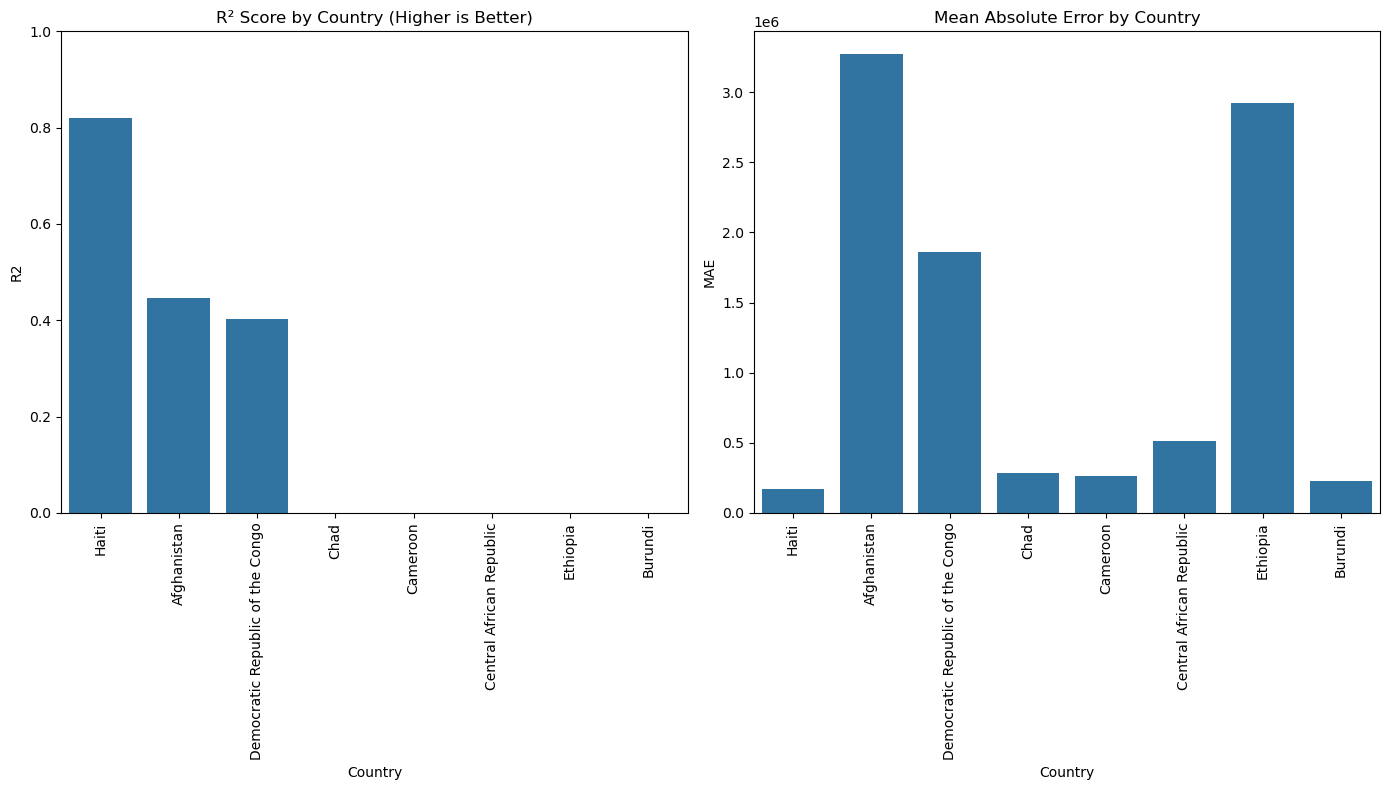

In [26]:
# Visualize performance metrics by country
plt.figure(figsize=(14, 8))

# Sort countries by R2 score
sorted_countries = performance_df.sort_values('R2', ascending=False)['Country'].tolist()

# Create bar chart for R2 scores
plt.subplot(1, 2, 1)
sns.barplot(x='Country', y='R2', data=performance_df, order=sorted_countries)
plt.title('R² Score by Country (Higher is Better)')
plt.xticks(rotation=90)
plt.ylim(0, 1)  # R2 is typically between 0 and 1

# Create bar chart for MAE
plt.subplot(1, 2, 2)
sns.barplot(x='Country', y='MAE', data=performance_df, order=sorted_countries)
plt.title('Mean Absolute Error by Country')
plt.xticks(rotation=90)

plt.tight_layout()
print("\nSaved performance comparison chart to 'country_performance_comparison.png'")

# Train country-specific models and analyze feature importance differences
print("\nAnalyzing feature importance by country...")

In [27]:
# Function to train a country-specific model and get feature importance
def get_country_feature_importance(country_name, full_data, country_col, 
                                 target_col='internally_displaced_persons'):
    """
    Trains a country-specific model and returns feature importance
    
    Args:
        country_name: Name of the country to analyze
        full_data: Original dataframe with country column
        country_col: Name of the country column
        target_col: Name of the target column
    
    Returns:
        DataFrame with feature importance for this country
    """
    # Get data for this country
    country_df = full_data[full_data[country_col] == country_name]
    
    if len(country_df) < 10:
        print(f"Insufficient data for {country_name} - skipping feature importance analysis")
        return None
    
    # Preprocess the country data
    country_X, country_y, _ = preprocess_data(country_df, target_col=target_col, country_col=country_col)
    
    # Ensure the country data has the same features as the main model
    missing_cols = set(X.columns) - set(country_X.columns)
    for col in missing_cols:
        country_X[col] = 0
    
    # Select only the columns used in the main model and in the same order
    country_X = country_X[X.columns]
    
    # Train a country-specific model
    country_model = RandomForestRegressor(n_estimators=100, random_state=42)
    country_model.fit(country_X, country_y)
    
    # Get feature importance
    importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': country_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    return importance

# Create feature importance visualization for each country
plt.figure(figsize=(20, 15))

<Figure size 2000x1500 with 0 Axes>

<Figure size 2000x1500 with 0 Axes>